# Twitter runs for 'Discovering Foodborne Illness in Online Restaurant Reviews'

This notebook presents the evaluation of twitter classifiers presented in the paper.

## Table of Contents

1. [Setup](#)
    1. [Data Ingestion](#) (Data is cleaned ahead of time)
    4. [Loading Models](#) (Model hyperparams are pre-tuned)
2. [Sick Task](#)
    1. [Logistic Regression](#)
    2. [Random Forest](#)
    3. [SVM](#)
    4. [Prototype](#)
3. [Multiple Task](#)
    1. [Logistic Regression](#)
    2. [Random Forest](#)
    3. [SVM](#)
    4. [Pipelined Logistic Regression](#)
    5. [Prototype](#)

# Setup

In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



In [20]:
import time
%matplotlib inline
from copy import deepcopy
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter('ignore')
import logging
logging.basicConfig(level=logging.DEBUG)

In [21]:
from experiments.baseline_experiment_util import *
from experiments.baseline_experiment_util import setup_baseline_data

In [22]:
random_seed = 0

## Data Ingestion

In [23]:
biased_data = setup_baseline_data(dataset='twitter', data_path='./data/twitter_data/',
                                  train_regime='biased', test_regime='biased', random_seed=random_seed)
silver_data = setup_baseline_data(dataset='twitter', data_path='./data/twitter_data/',
                                  train_regime='silver', test_regime='silver', random_seed=random_seed)
gold_data = setup_baseline_data(dataset='twitter', data_path='./data/twitter_data/',
                                  train_regime='gold', test_regime='gold', random_seed=random_seed)


KeyboardInterrupt: 

In [ ]:
# train setup
biased_text = np.array(biased_data['train_data']['text'])
biased_sick = np.array(biased_data['train_data']['is_foodborne'])
biased_mult = np.array(biased_data['train_data']['is_multiple'])
biased_weights = calc_train_importance_weights(biased_data['train_data']['is_biased'], biased_data['U'])

gold_text = np.array(gold_data['train_data']['text'])
gold_sick = np.array(gold_data['train_data']['is_foodborne'])
gold_mult = np.array(gold_data['train_data']['is_multiple'])
gold_weights = calc_train_importance_weights(gold_data['train_data']['is_biased'], gold_data['U'])

silver_text = np.array(silver_data['train_data']['text'])
silver_sick = np.array(silver_data['train_data']['is_foodborne'])
silver_mult = np.array(silver_data['train_data']['is_multiple'])
silver_weights = calc_train_importance_weights(silver_data['train_data']['is_biased'], silver_data['U'])

# test setup
test_data = silver_data['test_data']
B = 1000 # number of bootstrap test set resamples
all_results = {}

## Loading Models

In [ ]:
from experiments.lr_model import model as lr_model
from experiments.rf_model import model as rf_model
from experiments.svm_model import model as svm_model
from sklearn.externals import joblib

In [ ]:
# logistic regression sick models
best_sick_lr_biased = joblib.load('data/best_models_twitter/best_lr_sick_biased.pkl')
best_sick_lr_silver = joblib.load('data/best_models_twitter/best_lr_sick_silver.pkl')
best_sick_lr_gold = joblib.load('data/best_models_twitter/best_lr_sick_gold.pkl')

In [ ]:
# random forest sick models
best_sick_rf_biased = joblib.load('data/best_models_twitter/best_rf_sick_biased.pkl')
best_sick_rf_silver = joblib.load('data/best_models_twitter/best_rf_sick_silver.pkl')
best_sick_rf_gold = joblib.load('data/best_models_twitter/best_rf_sick_gold.pkl')

In [ ]:
# svm sick models
best_sick_svm_biased = joblib.load('data/best_models_twitter/best_svm_sick_biased.pkl')
best_sick_svm_silver = joblib.load('data/best_models_twitter/best_svm_sick_silver.pkl')
best_sick_svm_gold = joblib.load('data/best_models_twitter/best_svm_sick_gold.pkl')

## Sick Task

### Logistic Regression

In [ ]:
best_sick_lr_biased.fit(biased_text, biased_sick, logreg__sample_weight=biased_weights)
best_sick_lr_silver.fit(silver_text, silver_sick, logreg__sample_weight=silver_weights)
best_sick_lr_gold.fit(gold_text, gold_sick, logreg__sample_weight=gold_weights)
print

In [ ]:
start = time.time()
title = 'Logistic Regression Sick Biased'
all_results[title] = model_report(best_sick_lr_biased, title, 'is_foodborne',
                                  test_data=test_data,
                                  save_fname='figures/sick_lr_biased',
                                  B=B, random_seed=random_seed)
print '\n{} seconds for evaluation'.format(int(time.time()-start))

In [ ]:
start = time.time()
title = 'Logistic Regression Sick Silver'
all_results[title] = model_report(best_sick_lr_silver, title, 'is_foodborne', 
                                  test_data=test_data,
                                  save_fname='figures/sick_lr_silver',
                                  B=B, random_seed=random_seed)
print '\n{} seconds'.format(int(time.time()-start))

In [ ]:
start = time.time()
title = 'Logistic Regression Sick Gold'
all_results[title] = model_report(best_sick_lr_gold, title, 'is_foodborne', 
                                  test_data=test_data,
                                  save_fname='figures/sick_lr_gold',
                                  B=B, random_seed=random_seed)
print '\n{} seconds'.format(int(time.time()-start))

### Precision Recall Tradeoffs

We'd like to explore how we lose precision with the LR models, as we gain recall. This can be visualized by looking at the high recall region of the PR curves. 

In the curve we can see that all of the model precision begins to drop around a recall of .8 start to significantly drop precision around a recall of .9

In [ ]:
pr_curves([best_sick_lr_biased, best_sick_lr_silver, best_sick_lr_gold], 
          ['"Sick" Logistic Regression Biased', 
           '"Sick" Logistic Regression Silver', 
           '"Sick" Logistic Regression Gold'], 
          'Precision-Recall Tradeoffs', 'is_foodborne', 
          dashes=[[20,5], [10,3], [5,1]],
          test_data=test_data, save_fname='paper_sick_lr',
          figsize=(6,4),
          xlim=(.5,1.),
          yticks=.1*np.arange(11))

In [ ]:
print_model_hyperparams(best_sick_lr_biased, 'Logistic Regression Sick Biased')
print
print_model_hyperparams(best_sick_lr_silver, 'Logistic Regression Sick Silver')
print
print_model_hyperparams(best_sick_lr_gold, 'Logistic Regression Sick Gold')
print

### Random Forest

In [34]:
best_sick_rf_biased.fit(biased_text, biased_sick, rf__sample_weight=biased_weights)
best_sick_rf_silver.fit(silver_text, silver_sick, rf__sample_weight=silver_weights)
best_sick_rf_gold.fit(gold_text, gold_sick, rf__sample_weight=gold_weights)
print


B: 999/1000                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

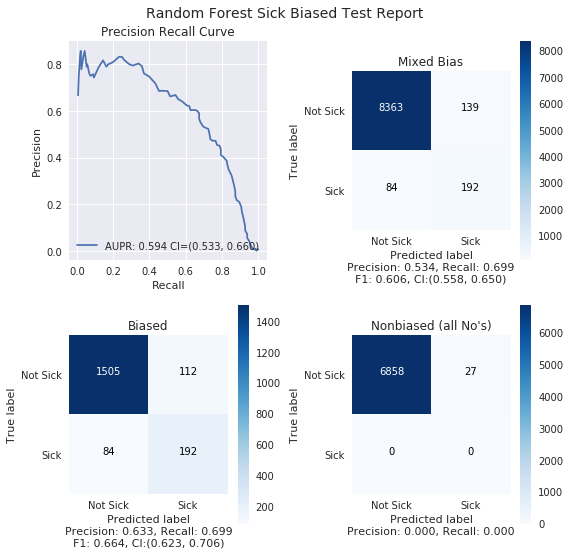

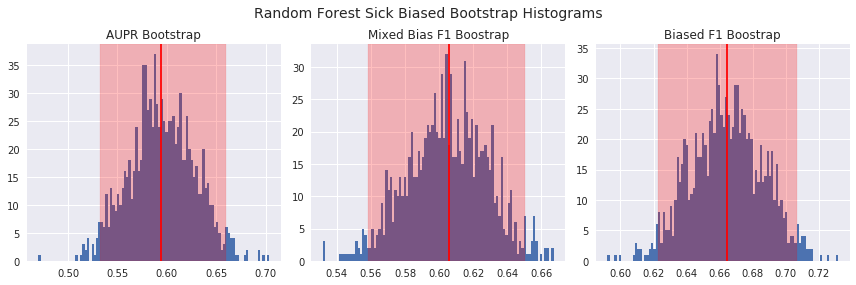

In [35]:
start = time.time()
title = 'Random Forest Sick Biased'
all_results[title] = model_report(best_sick_rf_biased, title, 'is_foodborne',
                                  save_fname='figures/sick_rf_biased',
                                  test_data=test_data,
                                  B=B, random_seed=random_seed)
print '\n{} seconds'.format(int(time.time()-start))


B: 999/1000                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

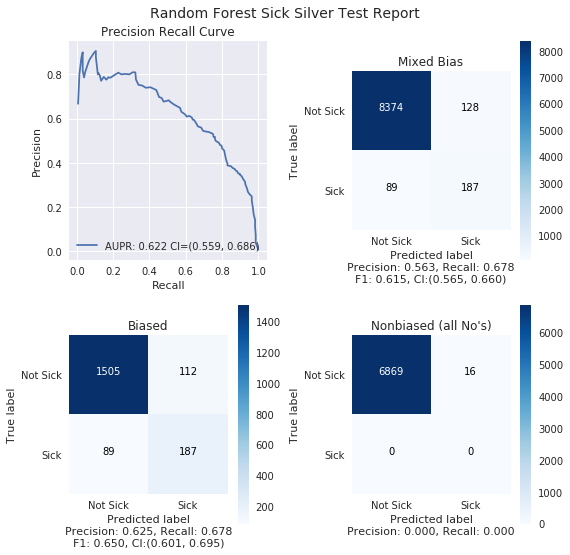

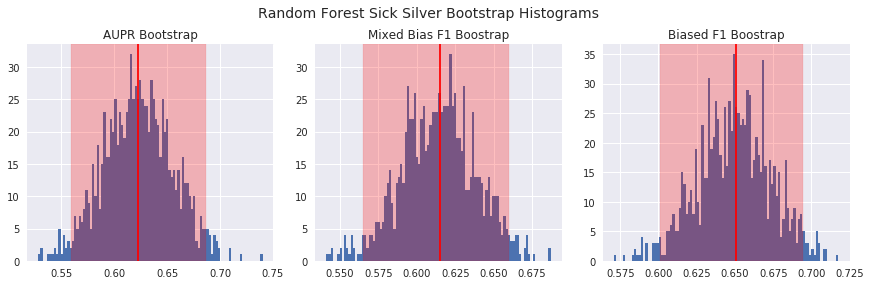

In [36]:
start = time.time()
title = 'Random Forest Sick Silver'
all_results[title] = model_report(best_sick_rf_silver, title, 'is_foodborne',
                                  save_fname='figures/sick_rf_silver',
                                  test_data=test_data,
                                  B=B, random_seed=random_seed)
print '\n{} seconds'.format(int(time.time()-start))


B: 999/1000                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

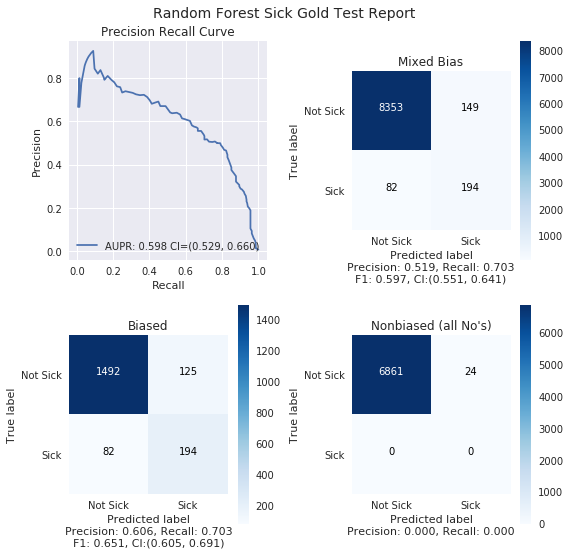

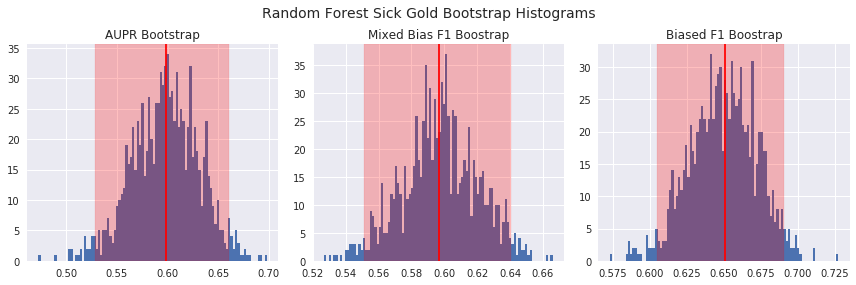

In [37]:
start = time.time()
title = 'Random Forest Sick Gold'
all_results[title] = model_report(best_sick_rf_gold, title, 'is_foodborne',
                                  save_fname='figures/sick_rf_gold',
                                  test_data=test_data,
                                  B=B, random_seed=random_seed)
print '\n{} seconds'.format(int(time.time()-start))

In [38]:
print_model_hyperparams(best_sick_rf_biased, 'Random Forest Sick Biased')
print
print_model_hyperparams(best_sick_rf_silver, 'Random Forest Sick Silver')
print
print_model_hyperparams(best_sick_rf_gold, 'Random Forest Sick Gold')
print

*** Random Forest Sick Biased Hyperparameters ***
{'count__analyzer': u'word',
 'count__binary': False,
 'count__decode_error': u'strict',
 'count__dtype': <type 'numpy.int64'>,
 'count__encoding': u'utf-8',
 'count__input': u'content',
 'count__lowercase': True,
 'count__max_df': 0.77767276498823101,
 'count__max_features': 1000,
 'count__min_df': 1,
 'count__ngram_range': (1, 2),
 'count__preprocessor': None,
 'count__stop_words': None,
 'count__strip_accents': None,
 'count__token_pattern': u'(?u)\\b\\w\\w+\\b',
 'count__tokenizer': None,
 'count__vocabulary': None,
 'rf__bootstrap': True,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'log2',
 'rf__max_leaf_nodes': None,
 'rf__min_impurity_split': 1e-07,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_estimators': 178,
 'rf__n_jobs': 1,
 'rf__oob_score': True,
 'rf__random_state': 0,
 'rf__verbose': 0,
 'rf__warm_start': False,

### SVM

In [24]:
best_sick_svm_biased.fit(biased_text, biased_sick, svc__sample_weight=biased_weights)
best_sick_svm_silver.fit(silver_text, silver_sick, svc__sample_weight=silver_weights)
best_sick_svm_gold.fit(gold_text, gold_sick, svc__sample_weight=gold_weights)
print


B: 999/1000                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

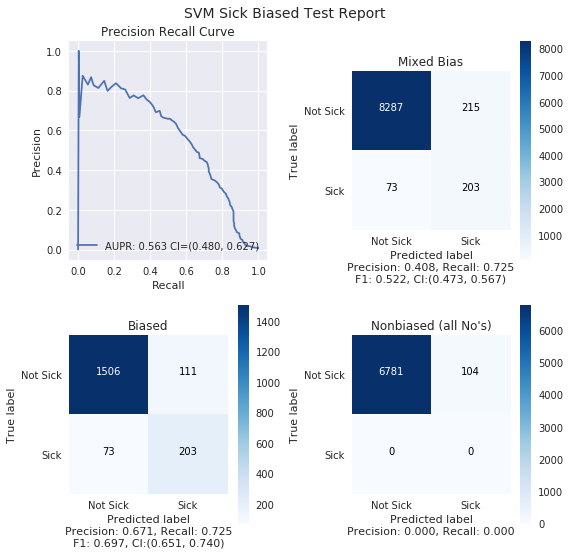

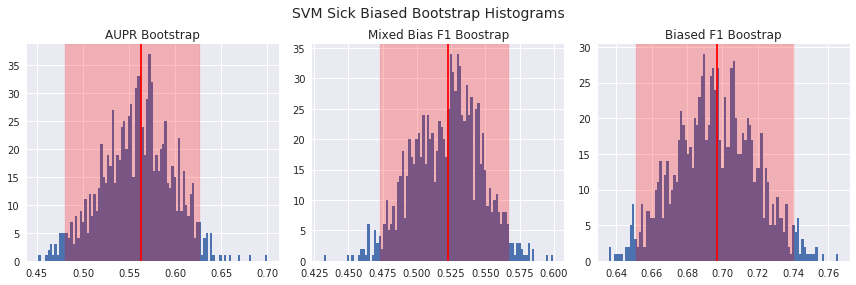

In [25]:
start = time.time()
title = 'SVM Sick Biased'
all_results[title] = model_report(best_sick_svm_biased, title, 'is_foodborne',
                                  save_fname='figures/sick_svm_biased',
                                  test_data=test_data,
                                  B=B, random_seed=random_seed)
print '\n{} seconds'.format(int(time.time()-start))


B: 999/1000                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

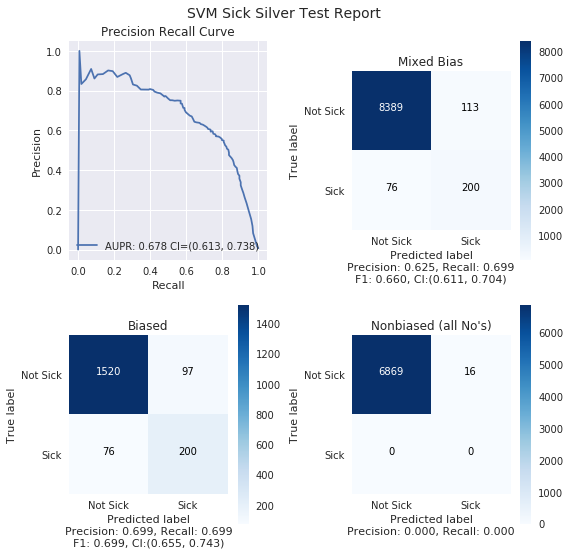

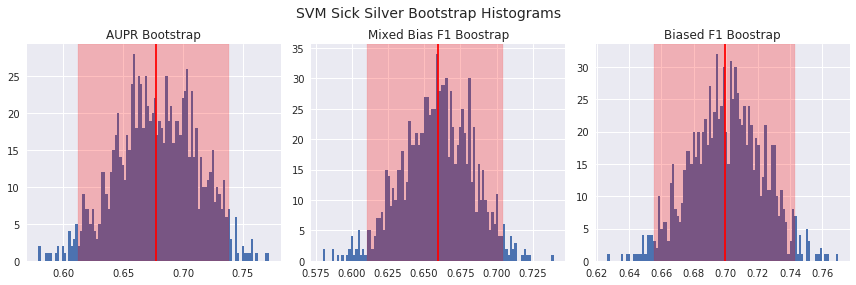

In [26]:
start = time.time()
title = 'SVM Sick Silver'
all_results[title] = model_report(best_sick_svm_silver, title, 'is_foodborne',
                                  save_fname='figures/sick_svm_silver',
                                  test_data=test_data,
                                  B=B, random_seed=random_seed)
print '\n{} seconds'.format(int(time.time()-start))


B: 999/1000                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

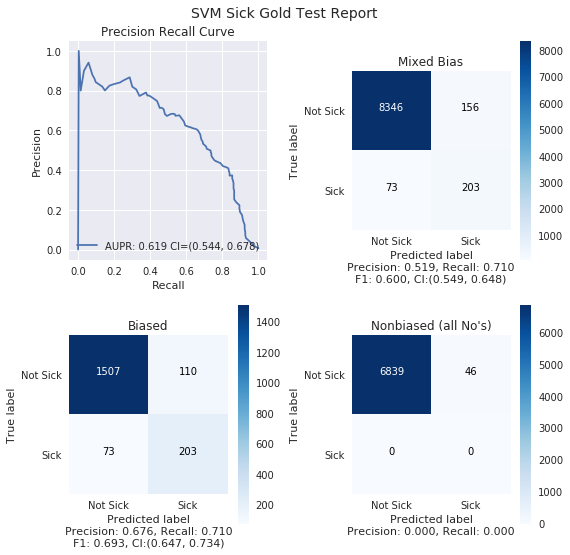

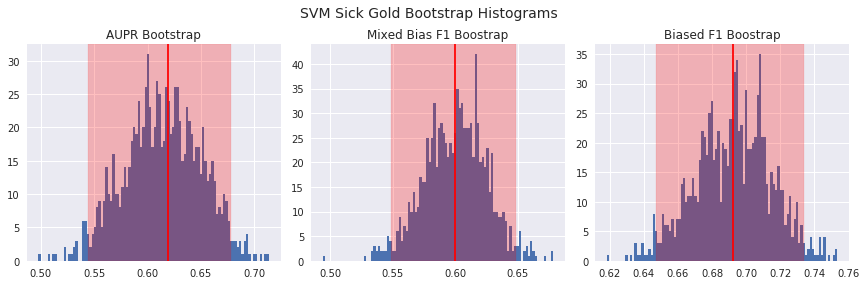

In [27]:
start = time.time()
title = 'SVM Sick Gold'
all_results[title] = model_report(best_sick_svm_gold, title, 'is_foodborne',
                                  save_fname='figures/sick_svm_gold',
                                  test_data=test_data,
                                  B=B, random_seed=random_seed)
print '\n{} seconds'.format(int(time.time()-start))

In [28]:
print_model_hyperparams(best_sick_svm_biased, 'SVM Sick Biased')
print
print_model_hyperparams(best_sick_svm_silver, 'SVM Sick Silver')
print
print_model_hyperparams(best_sick_svm_gold, 'SVM Sick Gold')
print

*** SVM Sick Biased Hyperparameters ***
{'count__analyzer': u'word',
 'count__binary': False,
 'count__decode_error': u'strict',
 'count__dtype': <type 'numpy.int64'>,
 'count__encoding': u'utf-8',
 'count__input': u'content',
 'count__lowercase': True,
 'count__max_df': 0.75894291577334649,
 'count__max_features': None,
 'count__min_df': 1,
 'count__ngram_range': (1, 2),
 'count__preprocessor': None,
 'count__stop_words': None,
 'count__strip_accents': None,
 'count__token_pattern': u'(?u)\\b\\w\\w+\\b',
 'count__tokenizer': None,
 'count__vocabulary': None,
 'svc__C': 0.071069812311930172,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': None,
 'svc__degree': 3,
 'svc__gamma': 'auto',
 'svc__kernel': 'linear',
 'svc__max_iter': -1,
 'svc__probability': True,
 'svc__random_state': None,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False,
 'tfidf__norm': None,
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': F

## Compile the scores into a nice table

In [39]:
sick_table = pd.DataFrame()
# mult_table = pd.DataFrame()
for name, result in sorted(all_results.items(), key=lambda x:x[0]):
    data = {k:v for k,v in result.items() if ('samples' not in k) and ('_ci' not in k) }
    data.update({k+'_b':v[0] for k,v in result.items() if '_ci' in k})
    data.update({k+'_t':v[1] for k,v in result.items() if '_ci' in k})
    data['name'] = name
    if 'Sick' in name:
        sick_table = sick_table.append(data, ignore_index=True)
    else:
        pass
        # mult_table = mult_table.append(data, ignore_index=True)
sick_table.set_index('name', inplace=True)
# mult_table.set_index('name', inplace=True)

In [40]:
print sick_table.columns

Index([u'aupr', u'aupr_ci_b', u'aupr_ci_t', u'biased_f1', u'biased_f1_ci_b',
       u'biased_f1_ci_t', u'biased_precision', u'biased_recall', u'mixed_f1',
       u'mixed_f1_ci_b', u'mixed_f1_ci_t', u'mixed_precision',
       u'mixed_recall'],
      dtype='object')


In [44]:
sick_table.to_csv('sick_results.csv')
sick_table[['mixed_f1', 'mixed_f1_ci_b', 'mixed_f1_ci_t']].to_csv('sick_results_small.csv')
sick_table[['mixed_f1', 'mixed_f1_ci_b', 'mixed_f1_ci_t']]

,mixed_f1,mixed_f1_ci_b,mixed_f1_ci_t
name,,,
Logistic Regression Sick Biased,0.556121,0.506390,0.605831
Logistic Regression Sick Gold,0.612608,0.564394,0.662408
Logistic Regression Sick Silver,0.641466,0.594086,0.686345
Random Forest Sick Biased,0.605595,0.558211,0.650318
Random Forest Sick Gold,0.596820,0.551092,0.640519
Random Forest Sick Silver,0.615277,0.565096,0.659968
SVM Sick Biased,0.522413,0.473312,0.567112
SVM Sick Gold,0.599575,0.548897,0.648370
SVM Sick Silver,0.659911,0.610580,0.704206


In [42]:
# mult_table.to_csv('mult_results.csv')
# mult_table[['mixed_f1', 'mixed_f1_ci_b', 'mixed_f1_ci_t']]

### Write out the final Sick and Multiple classifiers -- Sick LR Silver and Mult LR Pipelined Silver

In [45]:
joblib.dump(best_sick_lr_silver, 'final_models/final_twitter_sick_model_lr.gz')
joblib.dump(best_sick_svm_silver, 'final_models/final_twitter_sick_model.gz')

['final_models/final_twitter_sick_model.gz']